In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import pylab as plt
import matplotlib.patches as patches
from Bio import SeqIO
import shutil
import math

from evaluation_functions import read_filtering, read_sequences, get_variants, demultiplex_reads
from importlib import reload


In [2]:
## reload the evaluation functions
import evaluation_functions
reload(evaluation_functions)
from evaluation_functions import read_filtering, read_sequences, get_variants, demultiplex_reads

In [46]:
base_dir = os.getcwd()
R5_Pool_seq = "GGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTC"

catch_left = ""#"ACACTCTTTCCCTACACGACGCTCTTCCGATCT" ## Adapter fwd
catch_right = ""#"GACTGGAGTTCAGACGTGTGCTCTTCCGATCT"

Barcodes = {"BC1_Fwd": "AAGG",
            "BC1_Rev": "ATCA",
            "BC2_Fwd": "AGTC",
            "BC2_Rev": "GCCG",
            "BC3_Fwd": "AGGA",
            "BC3_Rev": "AATT",
            "BC4_Fwd": "GCGA",
            "BC4_Rev": "TGGT",
            "BC5_Fwd": "CCAT",
            "BC5_Rev": "GACC",
            "BC6_Fwd": "CTAG",
            "BC6_Rev": "CCAG",
            }

S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC"
S1_rev_primer = "TCGGCCAGTTCAGCCATTCA"
S1_rev_primer_compseq = dna_rev_comp(S1_rev_primer)
S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG"
S2_rev_primer = "TAGCACGGTCAGTCTCTGGC"
S2_rev_primer_compseq = dna_rev_comp(S2_rev_primer)
S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC"
S3_rev_primer = "ACATGCTGCGCCACGCTC"
S3_rev_primer_compseq = dna_rev_comp(S3_rev_primer)
S4_fwd_primer = "GATAACCGCGTGCGCGAA"
S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
S4_rev_primer_compseq = dna_rev_comp(S4_rev_primer)

Primer_seq = dict(
            S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC",
            S1_rev_primer = "TCGGCCAGTTCAGCCATTCA",
            S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG",
            S2_rev_primer = "TAGCACGGTCAGTCTCTGGC",
            S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC",
            S3_rev_primer = "ACATGCTGCGCCACGCTC",
            S4_fwd_primer = "GATAACCGCGTGCGCGAA",
            S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
)

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())

quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}

Primer_out_of_triplets = {"S1_fwd_primer": 0, ##??
                     "S1_rev_primer": 1, 
                     "S2_fwd_primer": 2,
                     "S2_rev_primer": 1,
                     "S3_fwd_primer": 1,
                     "S3_rev_primer": 2,
                     "S4_fwd_primer": 0,
                     "S4_rev_primer": 0} ##??

In [47]:
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', ]#'.', '/']
variant1 = "S2S3alt3cyclesmut"#"Cycle2Mutagenesis"
variant1_used_BCs = ["BC1", "BC2", "BC3"] #["BC1", "BC2"]

variant2 = "S2S3alt3cyclesNegPos"#"Cycle2NegPos"
variant2_used_BCs = ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"]#["BC1", "BC2", "BC3", "BC4"]

### for repeated seq of S2, S3, different primers were used:
Primer_seq["S2_fwd_primer"] = "GCATTTTAGCGATCTGT"
Primer_seq["S3_fwd_primer"] = "TTCTGGAATTTATTTCA"


catch_left = catch_left
catch_right = catch_right

Sections = ["S2", "S3"]

a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections =Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)

a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)

all_reads = {**{variant1+"_"+key : value for key, value in Mutagenesis_reads.items()},**{variant2+"_"+key : value for key, value in NegPosSelection_reads.items()}}

all_ids = {**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},**{variant2+"_"+key : value for key, value in NegPos_ids.items()}}


total reads 64476
BC1
total forward reads before filtering 10790
total reverse reads before filtering 10790
total forward reads after filtering 8714
total reverse reads after filtering 8674
10790 reads
total forward reads before filtering 15302
total reverse reads before filtering 15302
total forward reads after filtering 13128
total reverse reads after filtering 12757
15302 reads
BC2
total forward reads before filtering 10377
total reverse reads before filtering 10377
total forward reads after filtering 8587
total reverse reads after filtering 8496
10377 reads
total forward reads before filtering 16433
total reverse reads before filtering 16433
total forward reads after filtering 13983
total reverse reads after filtering 14089
16433 reads
BC3
total forward reads before filtering 6947
total reverse reads before filtering 6947
total forward reads after filtering 5316
total reverse reads after filtering 5178
6947 reads
total forward reads before filtering 13894
total reverse reads before

In [48]:
for key, ids in all_ids.items():
    print(key, len(ids))
    Name = key.split("_")[0] 
    Read_dir = key.split("_")[-1] 
    input_file = f"data/fastq/{Name}_{Read_dir}_001.fastq"
    output_file = f"{key}_001.fastq"

    records = (r for r in SeqIO.parse(input_file, "fastq") if r.id in ids)
    count = SeqIO.write(records, output_file, "fastq")
    print("Saved %i records from %s to %s" % (count, input_file, output_file))
    if count < len(ids):
        print("Warning %i IDs not found in %s" % (len(ids)-count, input_file))

S2S3alt3cyclesmut_BC1_S2_R1 10790
Saved 10790 records from data/fastq/S2S3alt3cyclesmut_R1_001.fastq to S2S3alt3cyclesmut_BC1_S2_R1_001.fastq
S2S3alt3cyclesmut_BC1_S2_R2 10790
Saved 10790 records from data/fastq/S2S3alt3cyclesmut_R2_001.fastq to S2S3alt3cyclesmut_BC1_S2_R2_001.fastq
S2S3alt3cyclesmut_BC1_S3_R1 15302
Saved 15302 records from data/fastq/S2S3alt3cyclesmut_R1_001.fastq to S2S3alt3cyclesmut_BC1_S3_R1_001.fastq
S2S3alt3cyclesmut_BC1_S3_R2 15302
Saved 15302 records from data/fastq/S2S3alt3cyclesmut_R2_001.fastq to S2S3alt3cyclesmut_BC1_S3_R2_001.fastq
S2S3alt3cyclesmut_BC2_S2_R1 10377
Saved 10377 records from data/fastq/S2S3alt3cyclesmut_R1_001.fastq to S2S3alt3cyclesmut_BC2_S2_R1_001.fastq
S2S3alt3cyclesmut_BC2_S2_R2 10377
Saved 10377 records from data/fastq/S2S3alt3cyclesmut_R2_001.fastq to S2S3alt3cyclesmut_BC2_S2_R2_001.fastq
S2S3alt3cyclesmut_BC2_S3_R1 16433
Saved 16433 records from data/fastq/S2S3alt3cyclesmut_R1_001.fastq to S2S3alt3cyclesmut_BC2_S3_R1_001.fastq
S2S3al

IndexError: index 2 is out of bounds for axis 1 with size 2

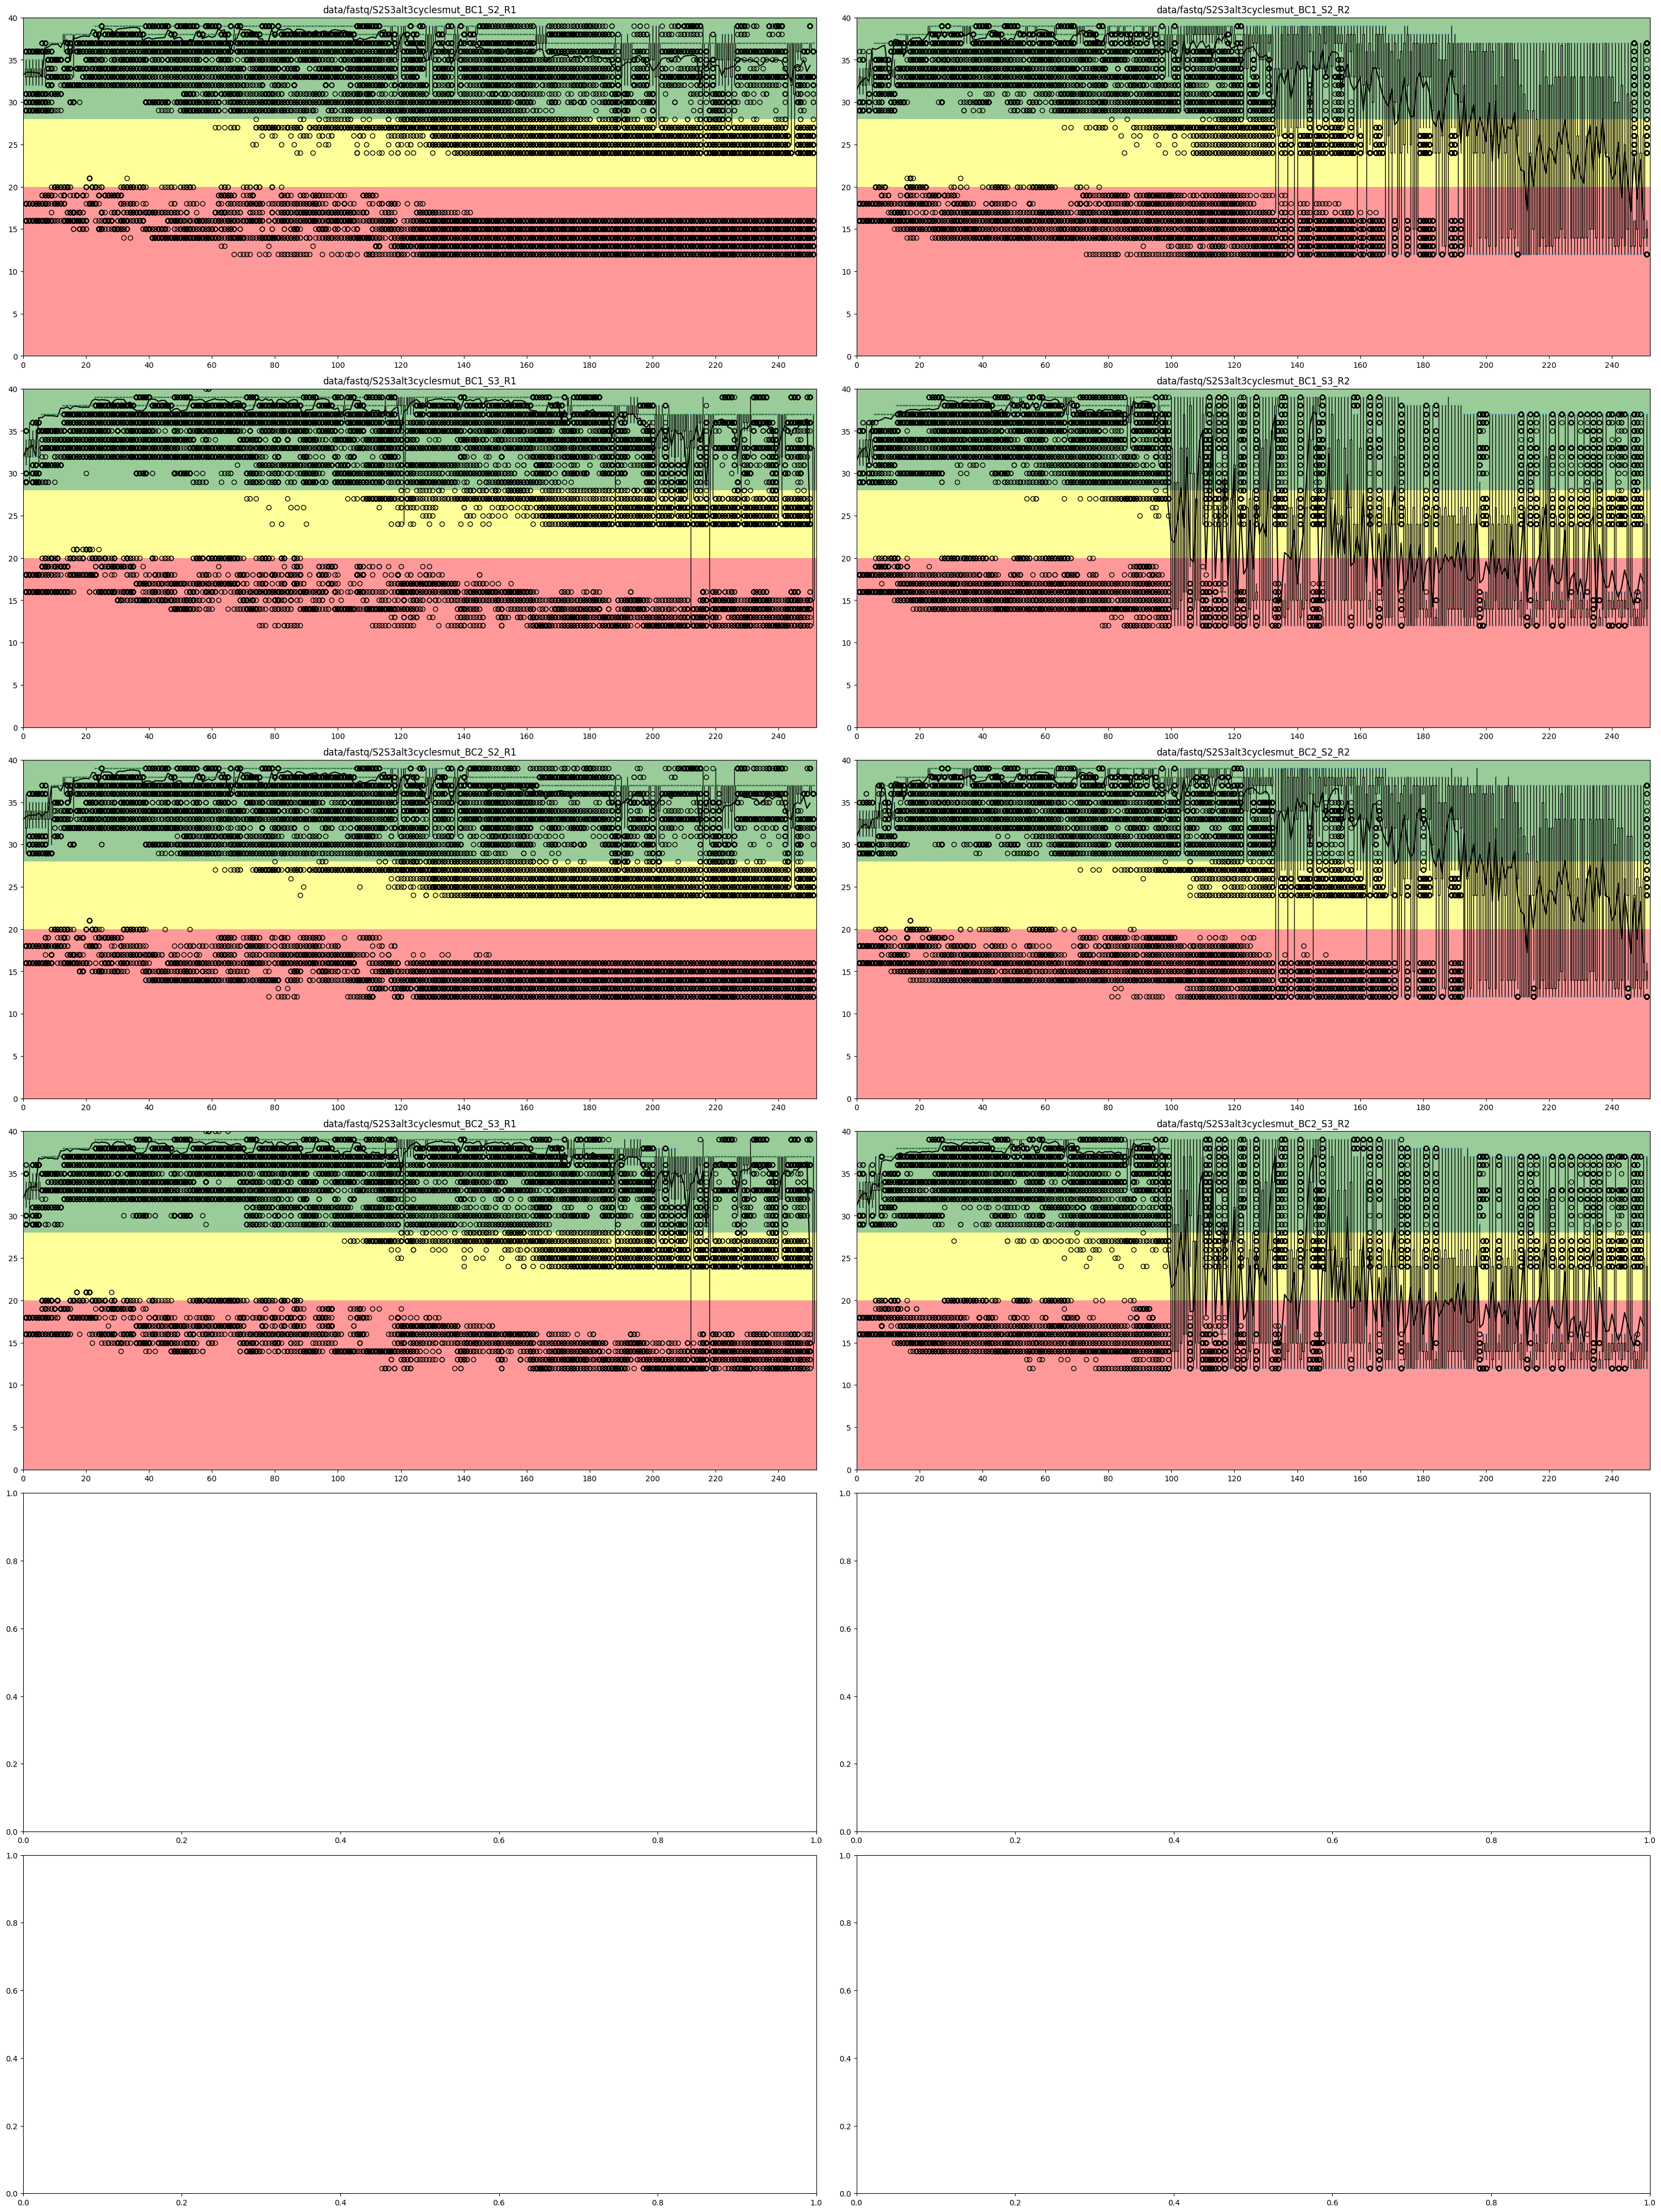

In [52]:
## figure with 4x4 plots of coverages: 
used_Barcodes = variant1_used_BCs #["BC1", "BC2"]
Sections = Sections

PANCE_step = variant1
read_dirs = ["R1", "R2"] # read directions


fig, axs = plt.subplots( len(used_Barcodes)*2, len(Sections), figsize=(len(used_Barcodes)*10, len(Sections)*20), layout='constrained')

axis_y = 0
x = 0
for Bc in used_Barcodes: 
    if Bc =="BC3":
        axis_y = 0
        x+=2
    for Section in  Sections:
        
        for read_dir in read_dirs:
            filename = f"data/fastq/{PANCE_step}_{Bc}_{Section}_{read_dir}_001.fastq"

            fastq_parser = SeqIO.parse(filename, "fastq")
            res=[]

            for record in fastq_parser:
                score=record.letter_annotations["phred_quality"]
                res.append(score)
            df = pd.DataFrame(res)
            l = len(df.T)+1
            
            ax = axs[axis_y, read_dirs.index(read_dir)+x]
            
            rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
            ax.add_patch(rect)
            rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
            ax.add_patch(rect)
            rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
            ax.add_patch(rect)
            df.mean().plot(ax=ax,c='black')
            boxprops = dict(linestyle='-', linewidth=1, color='black')
            df.plot(kind='box', ax=ax, grid=False, showfliers=True,
                    color=dict(boxes='black',whiskers='black')  )
            ax.set_xticks(np.arange(0, l, 20))
            ax.set_xticklabels(np.arange(0, l,20))
            
            ax.set_xlim((0,l))
            ax.set_ylim((0,40))
            ax.set_title(filename.split(".")[0][:-4])
        axis_y+=1
    
fig.supxlabel('position(bp)')
fig.supylabel('phred score')
plt.show()

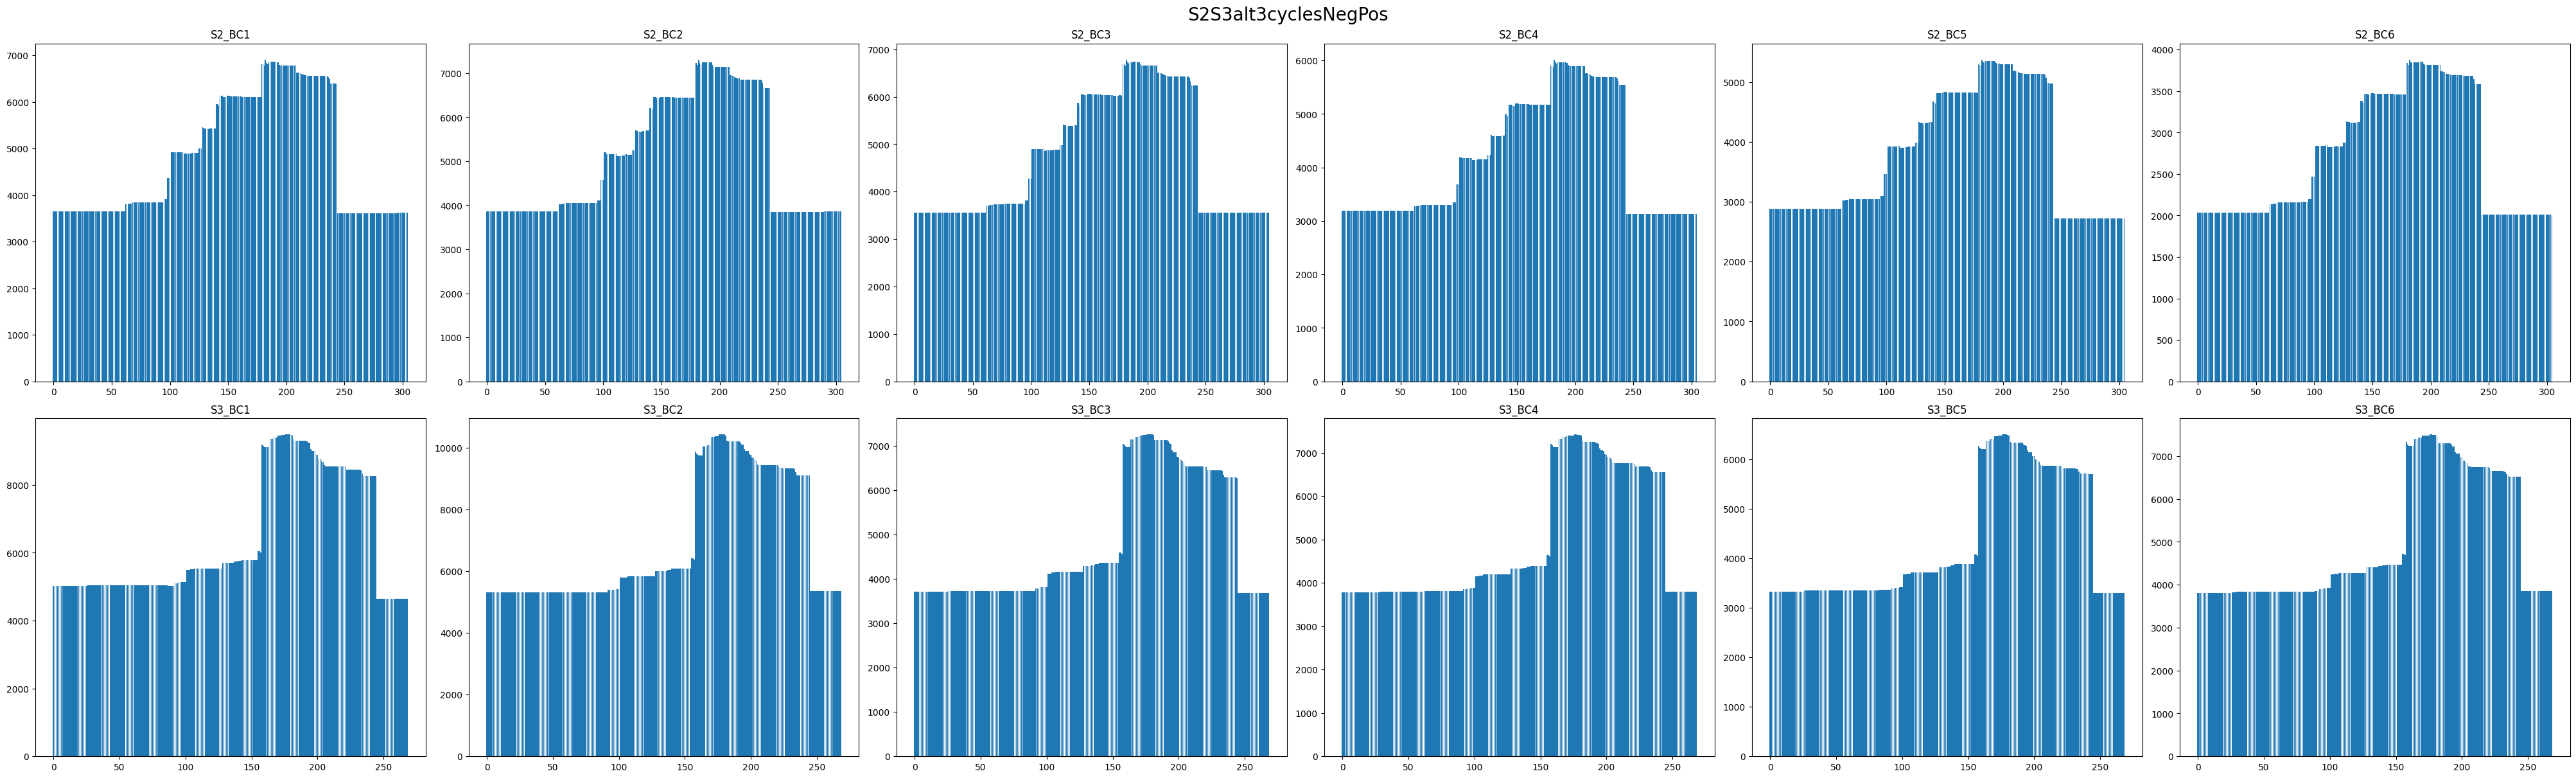

In [59]:
## figure with 4x4 plots of coverages: 
read_dictionary = NegPosSelection_reads # Mutagenesis reads
plt_title = variant2
used_Barcodes = variant2_used_BCs 
Sections = Sections


fig, axs = plt.subplots(len(Sections), len(used_Barcodes), figsize=(len(Sections)*20, len(used_Barcodes)*2), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))

for Bc in used_Barcodes: 
    for Section in  Sections:
        name = f"{Bc}_{Section}"

        tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
        tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
        ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
        ref_prot_section = translate_dna2aa(ref_seq_Section)

        seq_variants = get_variants(read_dictionary[f"{Bc}_{Section}_R1"], read_dictionary[f"{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]), ref_prot = ref_prot_section, ref_gene = ref_seq_Section, codons = codons)

        seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants["DNA"])
        #seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
        seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants["AA"])
        #seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
        seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants["Codons"])
        #seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

        ax = axs[Sections.index(Section), used_Barcodes.index(Bc)]
        ax.bar(seq_variants["DNA"].sum().index, seq_variants["DNA"].sum())
        ax.set_title(f'{Section}_{Bc}')
    
fig.suptitle(plt_title, fontsize = 20)                                                                  
plt.show()